In [2]:
# importing libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'webster-data445-bucket'
bucket = s3.Bucket(bucket_name)

# defining the train csv file
file_key = 'fraud_train.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the csv file
train = pd.read_csv(file_content_stream, sep = '|')
# dropping missing values
train = train.dropna()
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [8]:
# feature 1
train['total_per_trust_level'] = train['grandTotal'] / train['trustLevel']

In [10]:
# feature 2
train['interaction_trust_voids'] = train['trustLevel'] * train['lineItemVoids']

In [11]:
# feature 3
train['interaction_voids_without_registration'] = train['scansWithoutRegistration'] * train['lineItemVoids']

In [12]:
# feature 4
train['interaction_quantityM_Time'] = train['quantityModifications'] * train['totalScanTimeInSeconds']

[Text(697.5, 713.475, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(348.75, 509.625, 'scannedLineItemsPerSecond <= 0.015\ngini = 0.383\nsamples = 267\nvalue = [198, 69]'),
 Text(174.375, 305.775, 'totalScanTimeInSeconds <= 1807.0\ngini = 0.096\nsamples = 119\nvalue = [113, 6]'),
 Text(87.1875, 101.92499999999995, 'gini = 0.067\nsamples = 116\nvalue = [112, 4]'),
 Text(261.5625, 101.92499999999995, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(523.125, 305.775, 'totalScanTimeInSeconds <= 895.0\ngini = 0.489\nsamples = 148\nvalue = [85, 63]'),
 Text(435.9375, 101.92499999999995, 'gini = 0.357\nsamples = 103\nvalue = [79, 24]'),
 Text(610.3125, 101.92499999999995, 'gini = 0.231\nsamples = 45\nvalue = [6, 39]'),
 Text(1046.25, 509.625, 'total_per_trust_level <= 49.153\ngini = 0.022\nsamples = 1236\nvalue = [1222, 14]'),
 Text(871.875, 305.775, 'trustLevel <= 2.5\ngini = 0.018\nsamples = 1229\nvalue = [1218, 11]'),
 Text(784.6875, 101.92499999999995, 'g

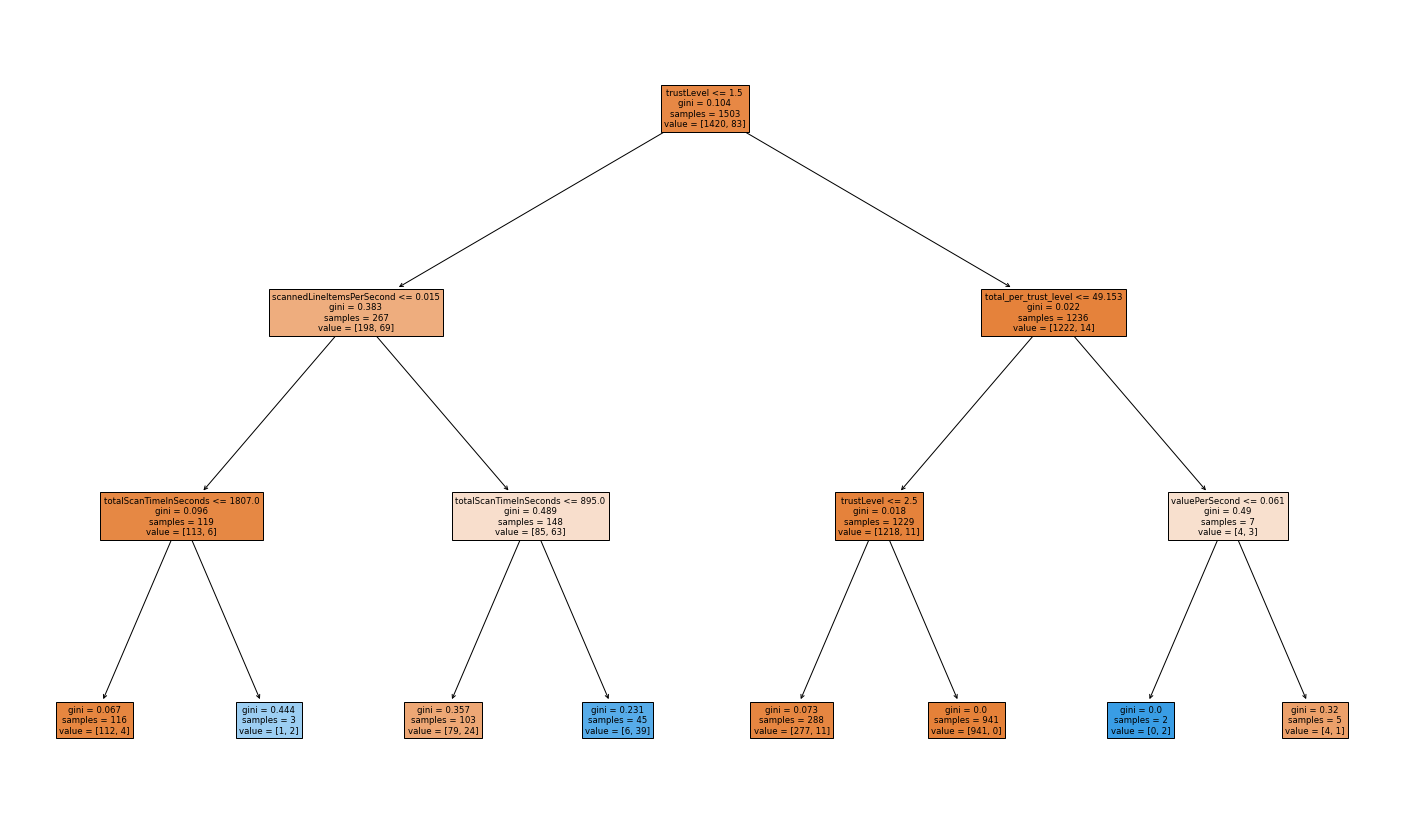

In [13]:
# defining input and target variables
X = train.drop(columns = ['fraud'], axis = 1)
Y = train['fraud']

# splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

# building decision tree model
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

# visualizing decision tree results
fig = plt.figure(figsize =(25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

In [14]:
# feature 5
train['interaction_5'] = np.where((train['trustLevel'] <= 1.5) & (train['total_per_trust_level'] <= 49.153) & (train['trustLevel'] <= 2.5), 1, 0)

In [15]:
# feature 6
train['interaction_quantity_voids'] = train['quantityModifications'] * train['lineItemVoids']

In [16]:
# feature 7
train['interaction_value_voids'] = train['valuePerSecond'] * train['lineItemVoids']

In [20]:
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,total_per_trust_level,interaction_trust_voids,interaction_voids_without_registration,interaction_quantityM_Time,interaction_5,interaction_quantity_voids,interaction_value_voids
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,10.940,1.206897,0,3162,0,21,0.363283
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,9.120,1.071429,10,432,0,20,1.266667
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,20.720,0.692308,30,7580,0,15,0.123008
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,15.385,1.655172,32,7164,0,32,0.412328
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,16.306,0.555556,21,860,0,6,0.568814
